# Experimenting with News and Tone Analyzer API's

First I begin by using the google news API

In [1]:
import requests
from pprint import pprint
import pandas as pd
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import BasicAuthenticator
import json
import os
from os.path import join
from ibm_watson import ToneAnalyzerV3
from ibm_watson.tone_analyzer_v3 import ToneInput
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pyprojroot import here

In [2]:
with open(here("environ.yaml")) as file:
    api_keys = yaml.load(file, Loader=yaml.FullLoader)


In [3]:
response = requests.get('http://newsapi.org/v2/everything?'
       'q=COVID-19&'
       'from=2020-04-08&'
       'to=2020-04-22&'
       'sortBy=popularity&'
       'languages=en&'
       'pageSize=100&'
       f'apiKey={api_keys["news_api_key"]}')
data = response.json()
#pprint(data)

In [4]:
pd.DataFrame.from_dict( data["articles"][5]).iloc[[1]]

,source,author,title,description,url,urlToImage,publishedAt,content
name,Lifehacker.com,Brendan Hesse and David Murphy,The Simplest Video Chat Apps for People Who St...,Social distancing is crucial to reducing COVID...,https://lifehacker.com/the-simplest-video-chat...,https://i.kinja-img.com/gawker-media/image/upl...,2020-04-09T20:30:00Z,Social distancing is crucial to reducing COVID...


In [5]:
articles_df = pd.concat(    
    [pd.DataFrame.from_dict(article).iloc[[1]] for article in data["articles"]]
).reset_index()

In [6]:
print(articles_df["title"])

0     Assist COVID-19 Research by Sharing Your Fitbi...
1     Sorry, We Did Not All Get and Recover From COV...
2     Now You Can Find a COVID-19 Testing Center Usi...
3     You Can Get Two Months of Stadia Pro For Free ...
4     Don't Count on Getting a Refund From Ticketmas...
                            ...                        
95           Plz Donate in Exchange for Celebrity Nudes
96    Thanks to Sheltering in Place, Animal Shelters...
97    The Pandemic Could Be an Opportunity to Remake...
98       The US Is Waging War on Digital Trade Barriers
99    Stockholm's Subway Network is the World's Long...
Name: title, Length: 100, dtype: object


# Testing tone of title

In [7]:
#Authentication via IAM
authenticator = IAMAuthenticator(f'{api_keys["watson_api_key"]}')
service = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator)
service.set_service_url('https://gateway.watsonplatform.net/tone-analyzer/api')

In [8]:
# Authentication via external config like VCAP_SERVICES
service = ToneAnalyzerV3(version='2017-09-21',authenticator=authenticator)
service.set_service_url('https://gateway.watsonplatform.net/tone-analyzer/api')

In [9]:
def get_tone(text):
    this_tone = service.tone(
            tone_input=text,
            content_type="text/plain").get_result()
    return this_tone["document_tone"]

In [10]:
def get_num_tones(tone_dict):
    return len(tone_dict["tones"])

In [11]:
@np.vectorize
def get_tone_name(tone_dict,num_tone):
    if num_tone == 0:
        return "No Tone Available"
    else:
        return tone_dict["tones"][0]["tone_id"] 

In [12]:
ex = get_tone("Sorry, We Did Not All Get and Recover From")
print(ex)
print(get_num_tones(ex))

{'tones': [{'score': 0.70123, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]}
1


In [13]:
articles_df["tone"] = articles_df["title"].apply(get_tone)

In [14]:
articles_df["num_tones"] = articles_df["tone"].apply(get_num_tones)

In [15]:
articles_df["tone_name"] = get_tone_name(articles_df["tone"],articles_df["num_tones"])

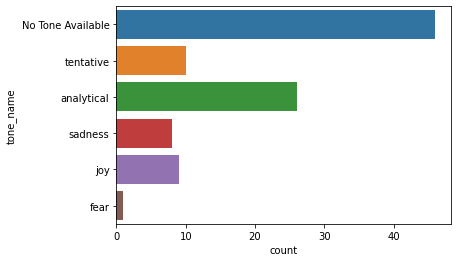

In [16]:
sns.countplot(y=articles_df["tone_name"])

In [17]:
articles_df.loc[articles_df["tone_name"]=="fear"]

,index,source,author,title,description,url,urlToImage,publishedAt,content,tone,num_tones,tone_name
53,name,Engadget,Jon Fingas,Discord beta reduces background noise during y...,Discord voice chats are particularly important...,https://www.engadget.com/discord-noise-suppres...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-04-10T20:24:01Z,Discord voice chats are particularly important...,"{'tones': [{'score': 0.586748, 'tone_id': 'fea...",1,fear
